In [1]:
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import classification_report, roc_auc_score, log_loss, average_precision_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from src.config import FE_DATA_PATH, SUBSAMPLE_FE_PATH, TARGET, SELECTED_FEATURES, HOLDOUT_PROCESSED 
from src.data_engineering import CategoricalEncoder
from src.model_eval import evaluate_model

%load_ext autoreload
%autoreload 2

 # I. Load Data

In [2]:
with open(SUBSAMPLE_FE_PATH, 'rb') as f:
    subsample_data = pickle.load(f)

Split train and test data

In [3]:
df_modelling = subsample_data[SELECTED_FEATURES+[TARGET]]

In [4]:
df_modelling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30773 entries, 57 to 19072
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   detailed_occupation_recode               30773 non-null  category
 1   major_occupation_code                    30773 non-null  object  
 2   education                                30773 non-null  object  
 3   detailed_industry_recode                 30773 non-null  category
 4   major_industry_code                      30773 non-null  object  
 5   detailed_household_and_family_stat       30773 non-null  object  
 6   class_of_worker                          30773 non-null  object  
 7   tax_filer_stat                           30773 non-null  object  
 8   detailed_household_summary_in_household  30773 non-null  object  
 9   marital_stat                             30773 non-null  object  
 10  family_members_under_18               

In [5]:
train_df, test_df = train_test_split(df_modelling, test_size=0.3, random_state=42, stratify=df_modelling[TARGET])
X_train, y_train = train_df[SELECTED_FEATURES], train_df[TARGET]
X_test, y_test = test_df[SELECTED_FEATURES], test_df[TARGET]

# II. Modelling

## 1. Catboost
Given the highest number of categorical features in the dataset, we can use catboost to natively handling such categorical features

In [6]:
weights = df_modelling[TARGET].value_counts(normalize=True)
weights = (1 - weights)
weight = weights[1]/weights[0]
weight

1.4853012437409139

In [7]:
cat_features = df_modelling.select_dtypes(['object', 'category']).columns.to_list()
cat_features

['detailed_occupation_recode',
 'major_occupation_code',
 'education',
 'detailed_industry_recode',
 'major_industry_code',
 'detailed_household_and_family_stat',
 'class_of_worker',
 'tax_filer_stat',
 'detailed_household_summary_in_household',
 'marital_stat',
 'family_members_under_18',
 'veterans_benefits',
 'sex',
 'full_or_part_time_employment_stat',
 'age_group']

In [8]:
# See Appendix for hyperparameter fine-tuning with Ray Tune
params = {'depth': 8,
 'iterations': 300,
 'l2_leaf_reg': 3.926164896351149,
 'learning_rate': 0.15802290866050492}

catboost_model = CatBoostClassifier(cat_features=cat_features, scale_pos_weight=weight, random_state=42, verbose=0, **params)
catboost_model.fit(X_train, y_train)

In [9]:
evaluate_model(catboost_model, X_test, y_test)

{'Accuracy': 0.8754332755632582,
 'Recall': 0.8952893674293405,
 'Precision': 0.8137998531930511,
 'F1 Score': 0.8526018969495002,
 'Average Precision Score': 0.9244027795327882,
 'ROC-AUC Score': 0.9507778599903248}

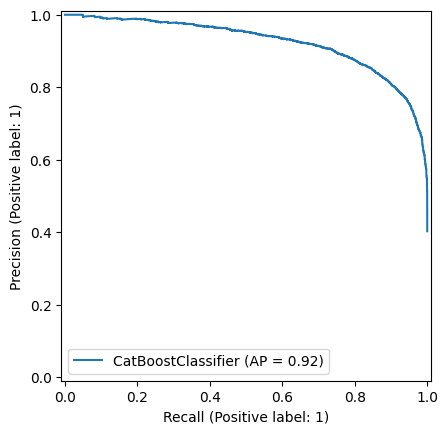

In [10]:
PrecisionRecallDisplay.from_estimator(catboost_model, X_test, y_test)

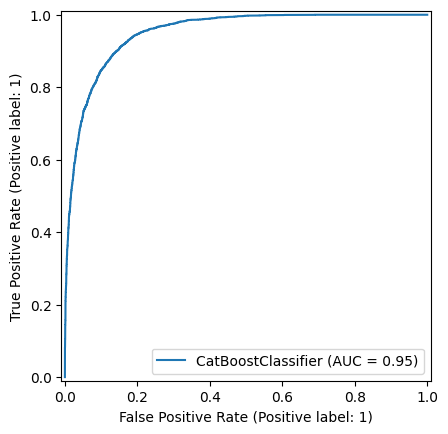

In [11]:
RocCurveDisplay.from_estimator(catboost_model, X_test, y_test)

In [12]:
# Feature importance
feature_importance = catboost_model.feature_importances_
feature_names = X_train.columns

feature_importance = (feature_importance / np.sum(feature_importance))
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
2,education,0.102431
0,detailed_occupation_recode,0.060020
16,age_group,0.059784
11,veterans_benefits,0.058463
19,dividends_from_stocks,0.057165
12,sex,0.056222
14,weeks_worked_in_year,0.055203
13,full_or_part_time_employment_stat,0.053879
17,capital_gains,0.053133
1,major_occupation_code,0.052777


## 2. Other estimators 
with explicit categorical transformation

### 2.1 transform categorical features

In [13]:
education_order = {
    "education": [
        "Children", "Less than 1st grade", "1st 2nd 3rd or 4th grade", "5th or 6th grade", 
        "7th and 8th grade", "9th grade", "10th grade", "11th grade", "12th grade no diploma", 
        "High school graduate", "Some college but no degree", "Associates degree-occup /vocational", 
        "Associates degree-academic program", "Bachelors degree(BA AB BS)", 
        "Masters degree(MA MS MEng MEd MSW MBA)", "Prof school degree (MD DDS DVM LLB JD)", 
        "Doctorate degree(PhD EdD)"
    ]
}

non_ordered_columns = [
    'major_occupation_code', 'major_industry_code', 'detailed_household_and_family_stat', 
    'class_of_worker', 'tax_filer_stat', 'detailed_household_summary_in_household', 
    'marital_stat', 'family_members_under_18', 'sex', 'full_or_part_time_employment_stat'
]

int_columns = ['detailed_occupation_recode', 'detailed_industry_recode', 'veterans_benefits', 'age_group']

In [14]:
encoder = CategoricalEncoder(ordered_categories=education_order, non_ordered_cols=non_ordered_columns, int_cols=int_columns)
df_transformed = encoder.fit_transform(df_modelling)
X_train_transformed, X_test_transformed =  df_transformed[SELECTED_FEATURES].loc[X_train.index], df_transformed[SELECTED_FEATURES].loc[X_test.index]

/mnt/CPP_JB/other/src/data_engineering.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.lstrip()  # Ensure consistent formatting


### 2.2 Train other models
- lightgbm
- ramdom forest
- logistic_regression

In [15]:
# catboost_model = CatBoostClassifier(iterations=500, cat_features=cat_features, verbose=0)
lgbm_model = LGBMClassifier(n_estimators=300, scale_pos_weight=weight, random_state=25)
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=25)
lr_model = LogisticRegression(max_iter=300, random_state=25)

In [16]:
lgbm_model.fit(X_train_transformed, y_train)
rf_model.fit(X_train_transformed, y_train)
lr_model.fit(X_train_transformed, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, random_state=25)

In [17]:
evaluate_model(lgbm_model, X_test_transformed, y_test)

{'Accuracy': 0.8757582322357019,
 'Recall': 0.8847913862718708,
 'Precision': 0.8205192211682476,
 'F1 Score': 0.8514441134568062,
 'Average Precision Score': 0.9241625950639312,
 'ROC-AUC Score': 0.9503829226243319}

In [18]:
evaluate_model(rf_model, X_test_transformed, y_test)

{'Accuracy': 0.869367417677643,
 'Recall': 0.8524899057873486,
 'Precision': 0.8279738562091503,
 'F1 Score': 0.840053050397878,
 'Average Precision Score': 0.9067418958095287,
 'ROC-AUC Score': 0.9413544968433554}

In [19]:
evaluate_model(lr_model, X_test_transformed, y_test)

{'Accuracy': 0.8360051993067591,
 'Recall': 0.8029609690444145,
 'Precision': 0.7922974767596281,
 'F1 Score': 0.7975935828877005,
 'Average Precision Score': 0.8737487203751486,
 'ROC-AUC Score': 0.9151911954021474}

## 3. Stacking models
Combining the power of all models above via stacking

In [20]:
train_preds = np.column_stack([
    catboost_model.predict_proba(X_train)[:,1],
    lgbm_model.predict_proba(X_train_transformed)[:,1],
    rf_model.predict_proba(X_train_transformed)[:,1],
    lr_model.predict_proba(X_train_transformed)[:,1]
])

test_preds = np.column_stack([
    catboost_model.predict_proba(X_test)[:,1],
    lgbm_model.predict_proba(X_test_transformed)[:,1],
    rf_model.predict_proba(X_test_transformed)[:,1],
    lr_model.predict_proba(X_test_transformed)[:,1]
])

meta_model = LogisticRegression()
meta_model.fit(train_preds, y_train)

LogisticRegression()

In [21]:
evaluate_model(meta_model, test_preds, y_test)

{'Accuracy': 0.8663344887348353,
 'Recall': 0.845222072678331,
 'Precision': 0.826533298236378,
 'F1 Score': 0.835773223316476,
 'Average Precision Score': 0.8912892153609983,
 'ROC-AUC Score': 0.932879139505422}

# III Out-Of-Sample Model Evaluation
Due to the imbalance of the dataset, accuracy and the ROC-AUC score can be misleading. Since we have no preference between recall and precision, we will use the F1 score (which combines both recall and precision) to compare the performance of different models.

Based on the F1 score, the meta-model (stacking) performs best in out-of-sample analysis (followed by random forest), suggesting that it has the strongest ability for generalisation.

In [22]:
with open(HOLDOUT_PROCESSED, 'rb') as f:
    oos_data = pickle.load(f)

In [23]:
X_oos, y_oos = oos_data[SELECTED_FEATURES], oos_data[TARGET]
X_oos_transformed = encoder.fit_transform(X_oos)

/mnt/CPP_JB/other/src/data_engineering.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.lstrip()  # Ensure consistent formatting


In [24]:
evaluate_model(catboost_model, X_oos, y_oos)

{'Accuracy': 0.8647033242650107,
 'Recall': 0.8616230197219528,
 'Precision': 0.29856598700425724,
 'F1 Score': 0.44346451451867874,
 'Average Precision Score': 0.611913692297746,
 'ROC-AUC Score': 0.9417429103604591}

In [25]:
evaluate_model(lgbm_model, X_oos_transformed, y_oos)

{'Accuracy': 0.8733603697448397,
 'Recall': 0.8831231813773036,
 'Precision': 0.3164754953076121,
 'F1 Score': 0.46596724667349027,
 'Average Precision Score': 0.6523067946727551,
 'ROC-AUC Score': 0.9511352958686711}

In [26]:
evaluate_model(rf_model, X_oos_transformed, y_oos)

{'Accuracy': 0.8847277986225589,
 'Recall': 0.8402845134173941,
 'Precision': 0.3330343413634034,
 'F1 Score': 0.47701202165733686,
 'Average Precision Score': 0.5796470271308329,
 'ROC-AUC Score': 0.9417732191037451}

In [27]:
evaluate_model(lr_model, X_oos_transformed, y_oos)

{'Accuracy': 0.8669181524894063,
 'Recall': 0.7636598771419334,
 'Precision': 0.2876804092320809,
 'F1 Score': 0.4179236519662052,
 'Average Precision Score': 0.4823256161117996,
 'ROC-AUC Score': 0.9100299535280936}

In [28]:
oos_meta_preds = np.column_stack([
    catboost_model.predict_proba(X_oos)[:,1],
    lgbm_model.predict_proba(X_oos_transformed)[:,1],
    rf_model.predict_proba(X_oos_transformed)[:,1],
    lr_model.predict_proba(X_oos_transformed)[:,1]
])

evaluate_model(meta_model, oos_meta_preds, y_oos)

{'Accuracy': 0.883392833665389,
 'Recall': 0.8344649207888781,
 'Precision': 0.32946132244064336,
 'F1 Score': 0.4724077971995973,
 'Average Precision Score': 0.5112130341301575,
 'ROC-AUC Score': 0.9347944221197301}

# IV. Feature Importance with shap

## 1. Global feature importance

### catboost

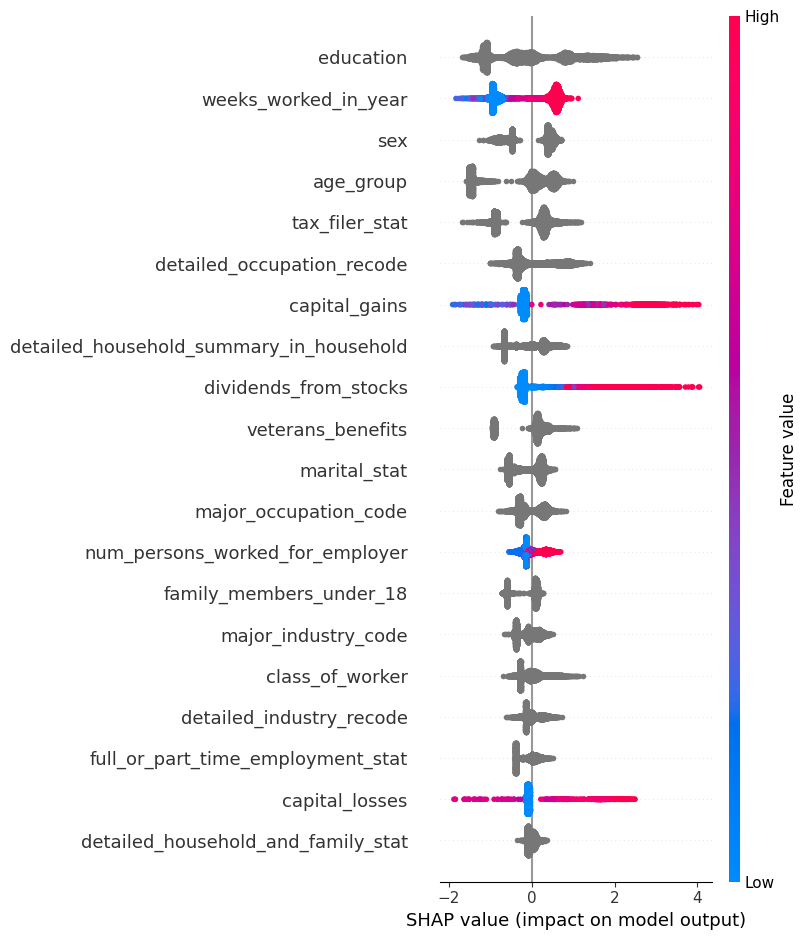

In [29]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### lightgbm

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


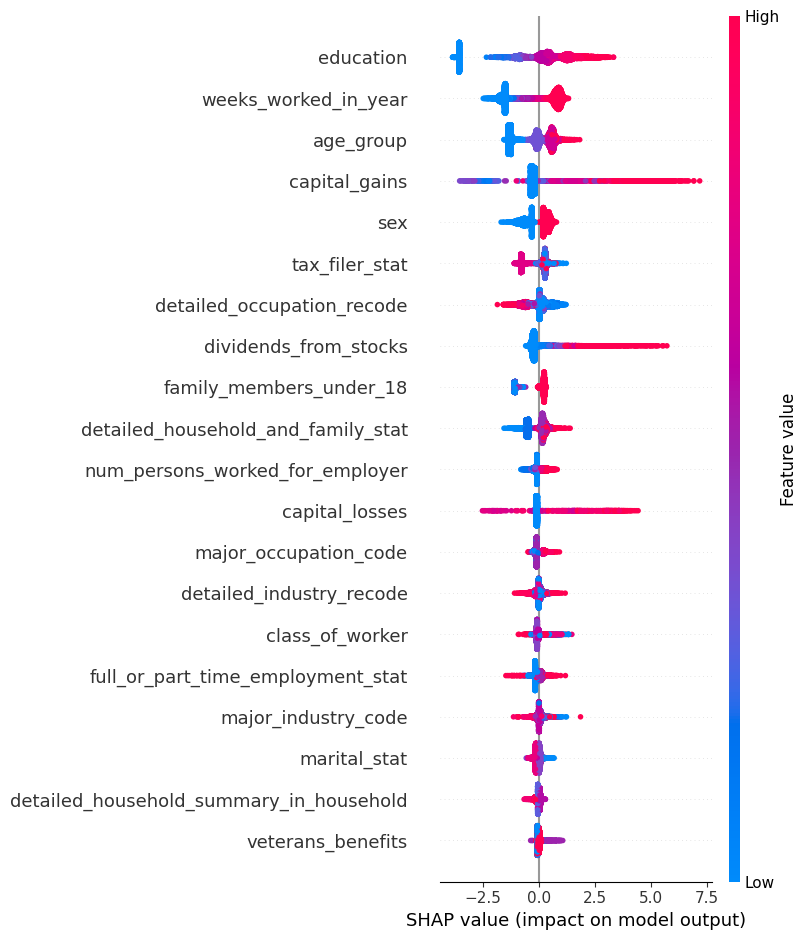

In [30]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed)

## 2. Local Feature Importance

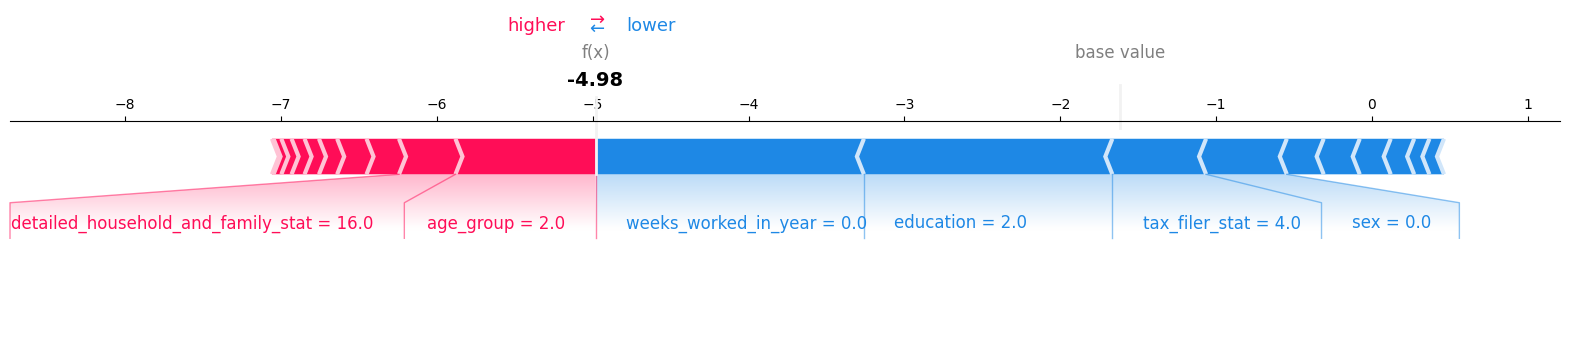

In [31]:
sample_index = 0
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test_transformed.iloc[sample_index], matplotlib=True)

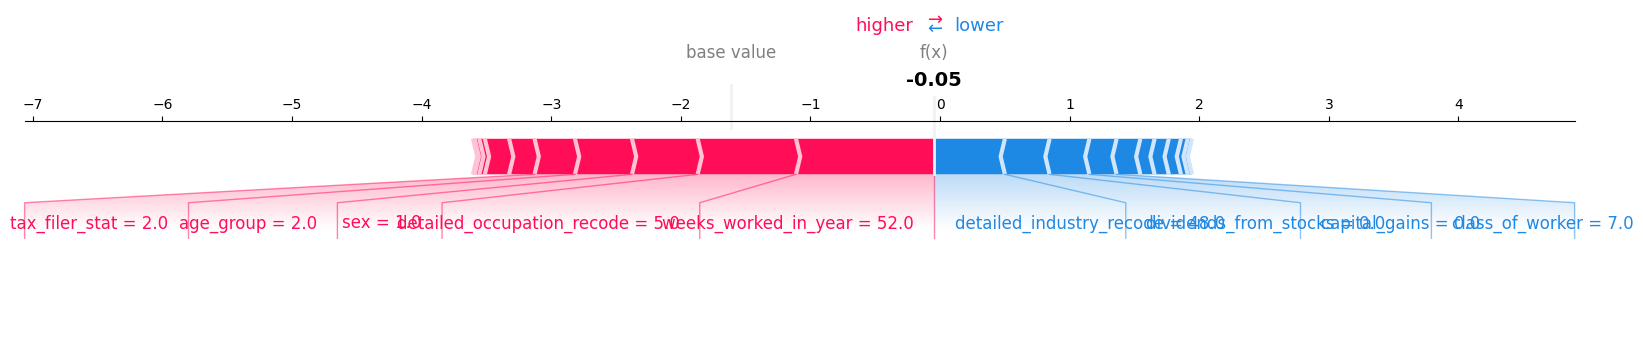

In [32]:
sample_index = 1
shap.force_plot(explainer.expected_value, shap_values[sample_index], X_test_transformed.iloc[sample_index], matplotlib=True)

# V. Feature Importance with Partial Dependence Plots

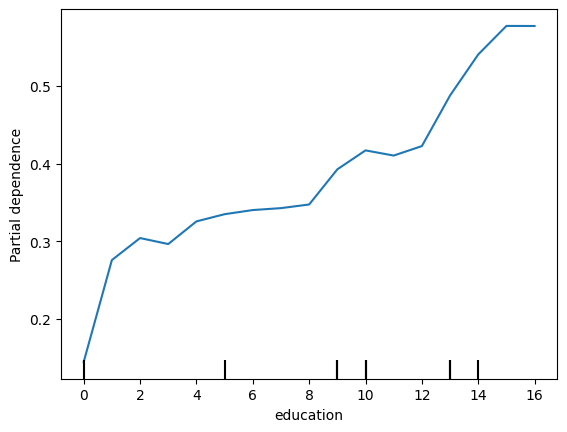

In [33]:
# Based on lgbm_model

feature = ['education']

PartialDependenceDisplay.from_estimator(lgbm_model, X_test_transformed, feature)
plt.show()

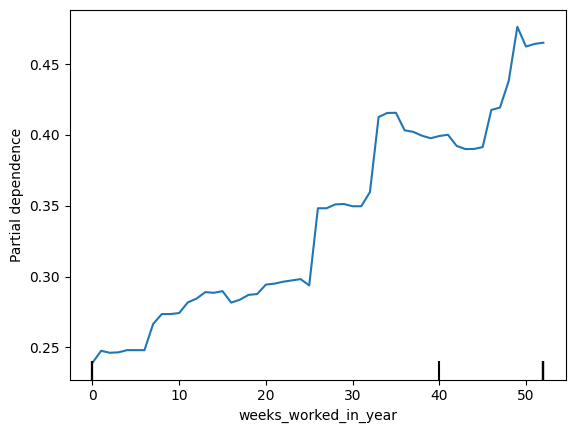

In [34]:
# Based on lgbm_model

feature = ['weeks_worked_in_year']

PartialDependenceDisplay.from_estimator(lgbm_model, X_test_transformed, feature)
plt.show()

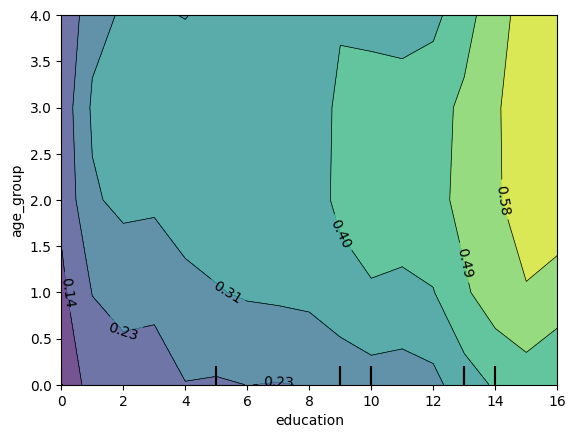

In [69]:
# Based on lgbm_model

feature = [('education' ,'age_group')]

PartialDependenceDisplay.from_estimator(lgbm_model, X_test_transformed, feature)
plt.show()

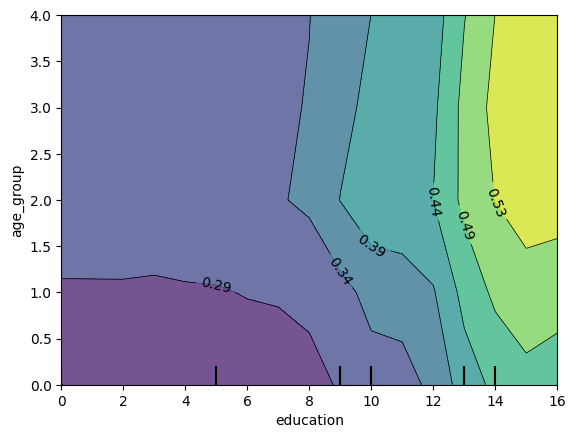

In [74]:
# Based on rf_model

feature = [('education' ,'age_group')]

PartialDependenceDisplay.from_estimator(rf_model, X_test_transformed, feature)
plt.show()

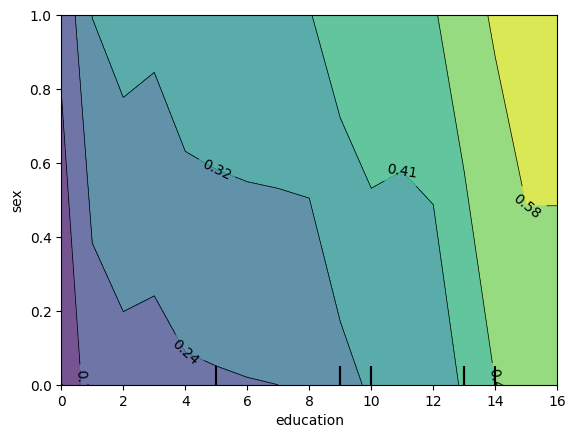

In [76]:
# Based on lgbm_model
feature = [('education' ,'sex')]

PartialDependenceDisplay.from_estimator(lgbm_model, X_test_transformed, feature)
plt.show()

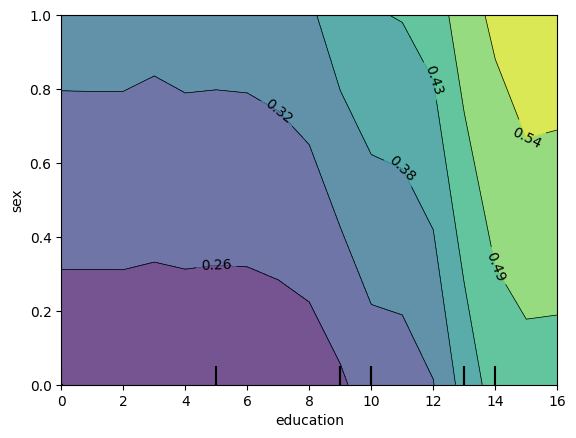

In [75]:
# Based on rf_model

feature = [('education' ,'sex')]

PartialDependenceDisplay.from_estimator(rf_model, X_test_transformed, feature)
plt.show()

In [89]:
X_test_transformed.columns

Index(['detailed_occupation_recode', 'major_occupation_code', 'education',
       'detailed_industry_recode', 'major_industry_code',
       'detailed_household_and_family_stat', 'class_of_worker',
       'tax_filer_stat', 'detailed_household_summary_in_household',
       'marital_stat', 'family_members_under_18', 'veterans_benefits', 'sex',
       'full_or_part_time_employment_stat', 'weeks_worked_in_year',
       'num_persons_worked_for_employer', 'age_group', 'capital_gains',
       'capital_losses', 'dividends_from_stocks'],
      dtype='object')

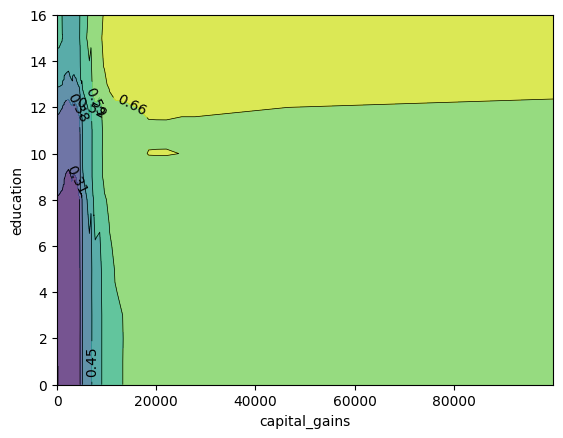

In [91]:
# Based on rf_model

feature = [('capital_gains' ,'education')]

PartialDependenceDisplay.from_estimator(rf_model, X_test_transformed, feature)
plt.show()

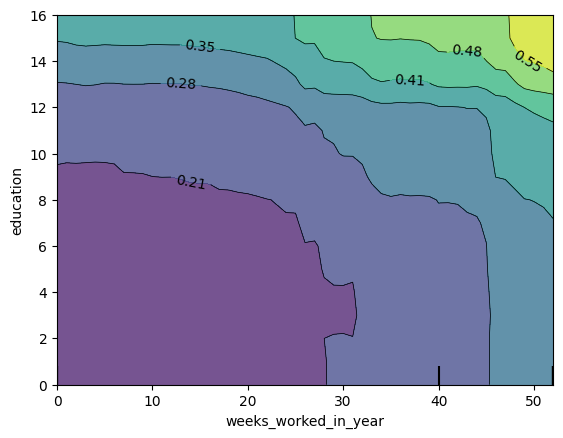

In [93]:
feature = [('weeks_worked_in_year' ,'education')]

PartialDependenceDisplay.from_estimator(rf_model, X_test_transformed, feature)
plt.show()

# Appendix I. AutoML

In [84]:
from flaml import AutoML

# Build model with Flaml
label = "automl_cv_model"
auto_clf_cv = AutoML()

weight = weights[1]/weights[0]
auto_clf_settings = {
    "time_budget": 100,  # in seconds
    "task": 'classification',
    "seed":42,
    "metric": "f1",
    "eval_method": 'cv', # cv, holdout
    "split_type": "stratified",
    "n_splits": 5,  
    "early_stop": True,
    "retrain_full": False,
    "estimator_list": ['xgboost', 'xgb_limitdepth','lgbm', 'rf', 'lrl2', 'catboost'], 
    "custom_hp":{
        "xgboost":{
            'scale_pos_weight':{
                'domain':weight,
                'init_value':weight
            },
        },
        'xgb_limitdepth':{
            'scale_pos_weight':{
                'domain':weight,
                'init_value':weight
            },
        },
        'rf':{
            "class_weight":{
                'domain':'balanced',
                'init_value':'balanced'
            }
        },
        'lgbm':{
            "scale_pos_weight":{
                'domain':weight,
                'init_value':weight
            }
        },
        'catboost':{
            "scale_pos_weight":{
                'domain':weight,
                'init_value':weight
            }
        }
    }
    
}

auto_clf_cv.fit(X_train=X_train, y_train=y_train,
           **auto_clf_settings)


[flaml.automl.logger: 03-17 16:55:56] {1728} INFO - task = classification
[flaml.automl.logger: 03-17 16:55:56] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 03-17 16:55:56] {1838} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 03-17 16:55:56] {1955} INFO - List of ML learners in AutoML Run: ['xgboost', 'xgb_limitdepth', 'lgbm', 'rf', 'lrl2', 'catboost']
[flaml.automl.logger: 03-17 16:55:56] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 03-17 16:55:56] {2393} INFO - Estimated sufficient time budget=8017s. Estimated necessary time budget=54s.
[flaml.automl.logger: 03-17 16:55:56] {2442} INFO -  at 0.9s,	estimator xgboost's best error=0.2318,	best estimator xgboost's best error=0.2318
[flaml.automl.logger: 03-17 16:55:56] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 03-17 16:55:57] {2442} INFO -  at 1.6s,	estimator lgbm's best error=0.2363,	best estimator xgboost's best error=0.2318
[flaml.automl.logger: 03-17 16

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[flaml.automl.logger: 03-17 16:57:14] {2442} INFO -  at 78.6s,	estimator lrl2's best error=0.2248,	best estimator lgbm's best error=0.1528
[flaml.automl.logger: 03-17 16:57:14] {2258} INFO - iteration 38, current learner lrl2
[flaml.automl.logger: 03-17 16:57:20] {2442} INFO -  at 84.8s,	estimator lrl2's best error=0.2234,	best estimator lgbm's best error=0.1528
[flaml.automl.logger: 03-17 16:57:20] {2258} INFO - iteration 39, current learner rf
[flaml.automl.logger: 03-17 16:57:21] {2442} INFO -  at 85.4s,	estimator rf's best error=0.1735,	best estimator lgbm's best error=0.1528
[flaml.automl.logger: 03-17 16:57:21] {2258} INFO - iteration 40, current learner xgboost
[flaml.automl.logger: 03-17 16:57:22] {2442} INFO -  at 86.8s,	estimator xgboost's best error=0.1548,	best estimator lgbm's best error=0.1528
[flaml.automl.logger: 03-17 16:57:22] {2258} INFO - iteration 41, current learner lgbm
[flaml.automl.logger: 03-17 16:57:23] {2442} INFO -  at 87.8s,	estimator lgbm's best error=0.1

In [85]:
auto_clf_cv.best_config_per_estimator

{'xgboost': {'n_estimators': 28,
  'max_leaves': 40,
  'min_child_weight': 2.813215490033363,
  'learning_rate': 0.17833729167608375,
  'subsample': 0.8676989550761623,
  'colsample_bylevel': 0.9761142820940875,
  'colsample_bytree': 0.9763763639565334,
  'reg_alpha': 0.0009765625,
  'reg_lambda': 6.40085221135825,
  'scale_pos_weight': 1.4853012437409139},
 'xgb_limitdepth': {'n_estimators': 10,
  'max_depth': 6,
  'min_child_weight': 0.9999999999999993,
  'learning_rate': 0.29999999999999993,
  'subsample': 1.0,
  'colsample_bylevel': 1.0,
  'colsample_bytree': 1.0,
  'reg_alpha': 0.0009765625,
  'reg_lambda': 1.0,
  'scale_pos_weight': 1.4853012437409139},
 'lgbm': {'n_estimators': 61,
  'num_leaves': 11,
  'min_child_samples': 13,
  'learning_rate': 0.21480951571013288,
  'log_max_bin': 6,
  'colsample_bytree': 0.996498378007316,
  'reg_alpha': 0.002255250947893723,
  'reg_lambda': 0.10239167483099826,
  'scale_pos_weight': 1.4853012437409139},
 'rf': {'n_estimators': 4,
  'max_fea

In [88]:
auto_clf_cv.model

In [86]:
evaluate_model(auto_clf_cv, X_test, y_test)

{'Accuracy': 0.8757582322357019,
 'Recall': 0.8993270524899057,
 'Precision': 0.812105007292173,
 'F1 Score': 0.8534934218929621,
 'Average Precision Score': 0.9247899889675888,
 'ROC-AUC Score': 0.9508642197577974}

# Appendix II. Hyperparameter Tuning with Ray Tune

In [77]:
import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from catboost import CatBoostClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
from hyperopt import hp

ray.init(ignore_reinit_error=True)

X, y = df_modelling[SELECTED_FEATURES], df_modelling[TARGET]

# define Hyperparameter Search Space
search_space = {
    "iterations": hp.choice("iterations", [100, 200, 300, 500]),
    "depth": hp.choice("depth", [4, 6, 8, 10]),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "l2_leaf_reg": hp.uniform("l2_leaf_reg", 1, 10),
}

# define Objective Function for Ray Tune
def objective(params):
    """Objective function for hyperparameter tuning with cross-validation."""
    params["iterations"] = int(params["iterations"])
    params["depth"] = int(params["depth"])
    
    # use cross-validation for more robust results
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # define model
    model = CatBoostClassifier(
        iterations=params["iterations"],
        depth=params["depth"],
        learning_rate=params["learning_rate"],
        l2_leaf_reg=params["l2_leaf_reg"],
        cat_features=cat_features, 
        scale_pos_weight=weight,
        verbose=False
    )
    
    # evaluate model using cross-validation
    scores = cross_val_score(model, X, y, cv=cv, scoring="f1")
    mean_accuracy = np.mean(scores)
    
    return {"loss": -mean_accuracy}

# Use HyperOptSearch for Hyperparameter Optimisation
algo = HyperOptSearch(search_space, metric="loss", mode="min")

analysis = tune.run(
    objective,
    search_alg=algo,
    num_samples=10, 
    metric="loss", mode="min"
)

# obtain best hyperparameters
best_params = analysis.best_config
print("Best Hyperparameters:", best_params)

ray.shutdown()


2025-03-17 16:50:33,316	WARNING services.py:2009 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67100672 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.80gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-03-17 16:50:34,540	INFO worker.py:1771 -- Started a local Ray instance.
2025-03-17 16:50:35,914	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,loss
objective_26faba2f,-0.849825
objective_d67c950e,-0.84765


2025-03-17 16:53:04,287	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/user/ray_results/objective_2025-03-17_16-50-35' in 0.0074s.
2025-03-17 16:53:04,294	INFO tune.py:1041 -- Total run time: 148.38 seconds (145.83 seconds for the tuning loop).


Best Hyperparameters: {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 3.926164896351149, 'learning_rate': 0.15802290866050492}


In [78]:
best_params

{'depth': 8,
 'iterations': 300,
 'l2_leaf_reg': 3.926164896351149,
 'learning_rate': 0.15802290866050492}